In [41]:
import wandb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

In [52]:
wandb.init(project="ms2-logistic-regression", entity="IFT6758_2024-B01", name="Logistic_Regression_Baseline")

In [43]:
# Load the dataset
df = pd.read_csv("../dataset/simple_engineered/augmented_data.csv")

In [31]:
# 1. ROC Curve and AUC
def roc_curve_and_auc(y_val, y_prob):
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

In [32]:
# 2. Goal Rate by Percentile (Binned by 5%)
def goal_rate_by_percentile(y_val, y_prob):
    df_val = pd.DataFrame({'y_val': y_val, 'y_prob': y_prob})
    df_val['percentile'] = pd.qcut(df_val['y_prob'], 100, labels=False, duplicates='drop') + 1  # Percentiles from 1 to 100
    goal_rate_by_percentile = df_val.groupby('percentile')['y_val'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(goal_rate_by_percentile.index, goal_rate_by_percentile, marker='o')
    plt.title("Goal Rate by Percentile")
    plt.xlabel("Model Percentile")
    plt.ylabel("Goal Rate (#goals / (#goals + #no_goals))")
    plt.show()


In [33]:
# 3. Cumulative Proportion of Goals by Percentile
def cumulative_proportion_of_goals(y_val, y_prob):
    df_val = pd.DataFrame({'y_val': y_val, 'y_prob': y_prob})
    cumulative_goals = df_val.sort_values('y_prob', ascending=False)['y_val'].cumsum()
    total_goals = df_val['y_val'].sum()
    cumulative_goal_percentage = cumulative_goals / total_goals

    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 1, len(cumulative_goal_percentage)), cumulative_goal_percentage, marker='o')
    plt.title("Cumulative Proportion of Goals by Model Percentile")
    plt.xlabel("Model Percentile")
    plt.ylabel("Cumulative Proportion of Goals")
    plt.show()

    # 4. Reliability Diagram (Calibration Curve)
    CalibrationDisplay.from_predictions(y_val, y_prob, n_bins=10, strategy='uniform')
    plt.title("Reliability Diagram (Calibration Curve)")
    plt.show()

In [53]:
features = ['distance_from_net', 'angle_from_net']
X = df[features]
X.fillna(X.mean(), inplace=True)
y = df['is_goal']
y.fillna(0, inplace=True)

/tmp/ipykernel_1361/1637390586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [54]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Logistic Regression Models
models = {
    "Distance Only": LogisticRegression().fit(X_train[['distance_from_net']], y_train),
    "Angle Only": LogisticRegression().fit(X_train[['angle_from_net']], y_train),
    "Distance + Angle": LogisticRegression().fit(X_train, y_train),
}

In [56]:
wandb.config.update({
    "features": features,
    "model_types": list(models.keys()),
    "test_size": 0.2,
    "random_state": 42,
})

In [57]:
# Predictions
predictions = {
    model_name: {
        "y_pred": model.predict(X_val[features_subset]),
        "y_prob": model.predict_proba(X_val[features_subset])[:, 1]
    }
    for model_name, (model, features_subset) in {
        "Distance Only": (models["Distance Only"], ['distance_from_net']),
        "Angle Only": (models["Angle Only"], ['angle_from_net']),
        "Distance + Angle": (models["Distance + Angle"], features)
    }.items()
}

In [58]:
for model_name, preds in predictions.items():
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_val, preds["y_prob"])
    roc_auc = auc(fpr, tpr)
    wandb.log({f"{model_name} ROC AUC": roc_auc})

    # Plot and log ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
    plt.title(f"ROC Curve: {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    wandb.log({f"{model_name} ROC Curve": wandb.Image(plt)})
    plt.close()

    # Goal Rate by Percentile
    df_val = pd.DataFrame({'y_val': y_val, 'y_prob': preds["y_prob"]})
    df_val['percentile'] = pd.qcut(df_val['y_prob'], 100, labels=False, duplicates='drop') + 1
    goal_rate_by_percentile = df_val.groupby('percentile')['y_val'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(goal_rate_by_percentile.index, goal_rate_by_percentile, marker='o')
    plt.title(f"Goal Rate by Percentile: {model_name}")
    plt.xlabel("Model Percentile")
    plt.ylabel("Goal Rate (#goals / (#goals + #no_goals))")
    wandb.log({f"{model_name} Goal Rate by Percentile": wandb.Image(plt)})
    plt.close()

    # Cumulative Proportion of Goals
    cumulative_goals = df_val.sort_values('y_prob', ascending=False)['y_val'].cumsum()
    total_goals = df_val['y_val'].sum()
    cumulative_goal_percentage = cumulative_goals / total_goals

    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 1, len(cumulative_goal_percentage)), cumulative_goal_percentage, marker='o')
    plt.title(f"Cumulative Proportion of Goals: {model_name}")
    plt.xlabel("Model Percentile")
    plt.ylabel("Cumulative Proportion of Goals")
    wandb.log({f"{model_name} Cumulative Proportion of Goals": wandb.Image(plt)})
    plt.close()

    # Reliability Diagram (Calibration Curve)
    CalibrationDisplay.from_predictions(y_val, preds["y_prob"], n_bins=10, strategy='uniform')
    plt.title(f"Reliability Diagram (Calibration Curve): {model_name}")
    wandb.log({f"{model_name} Reliability Diagram": wandb.Image(plt)})
    plt.close()
    


In [59]:
wandb.finish()

Angle Only ROC AUC,▁
Distance + Angle ROC AUC,▁
Distance Only ROC AUC,▁
Angle Only ROC AUC,0.49959
Distance + Angle ROC AUC,0.68972
Distance Only ROC AUC,0.68955


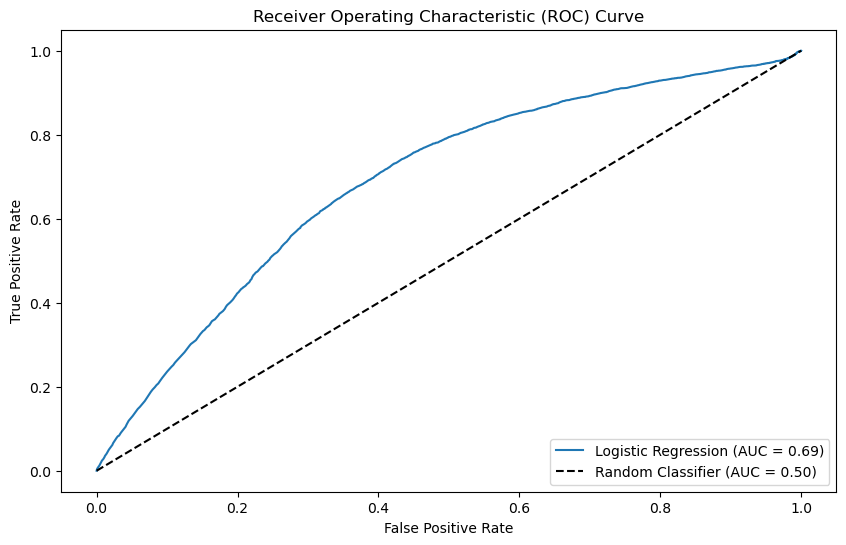

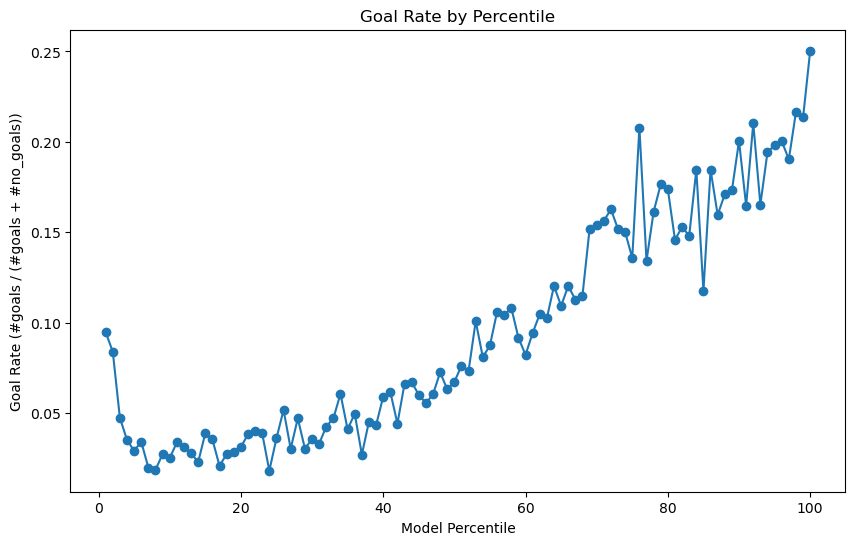

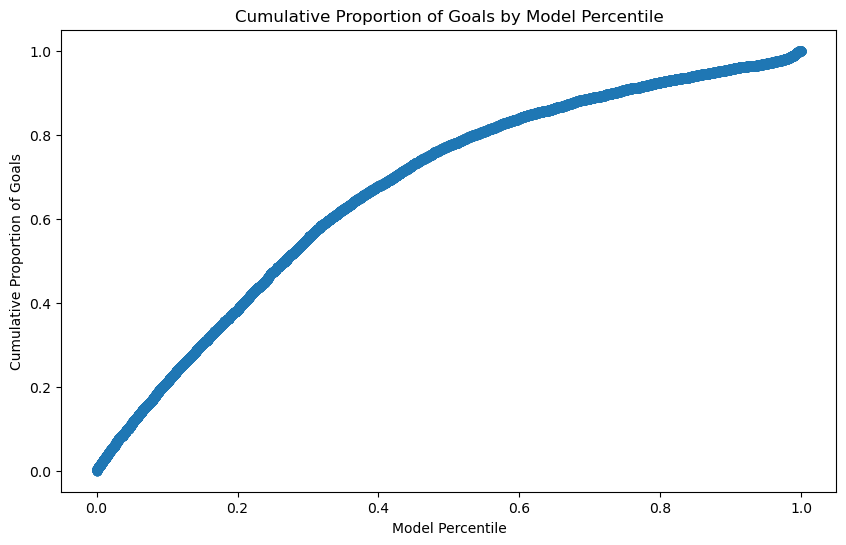

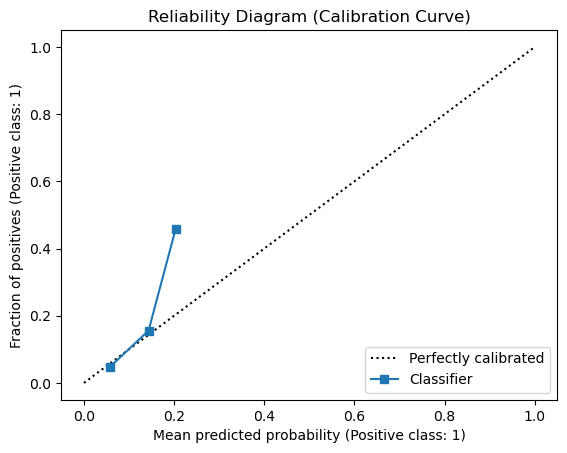

Distance Only Accuracy: 0.91


In [22]:
roc_curve_and_auc(y_val, predictions["Distance Only"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Distance Only"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Distance Only"]["y_prob"])

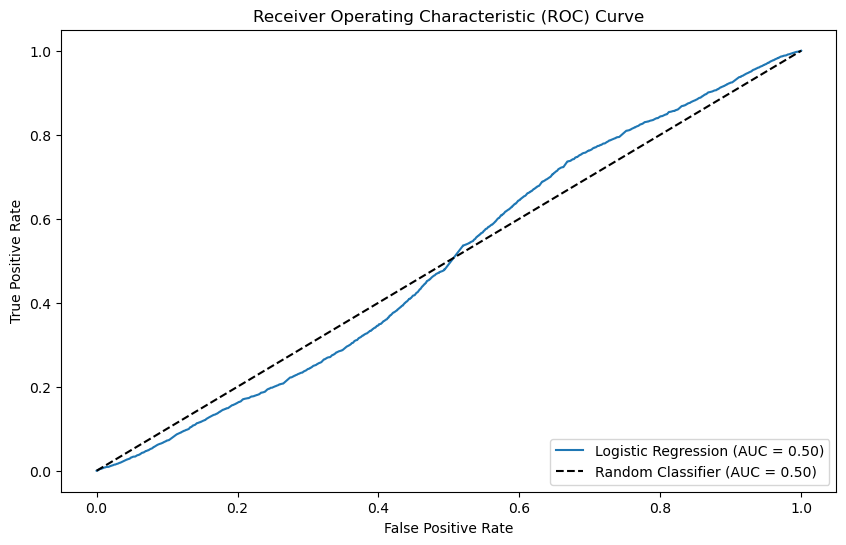

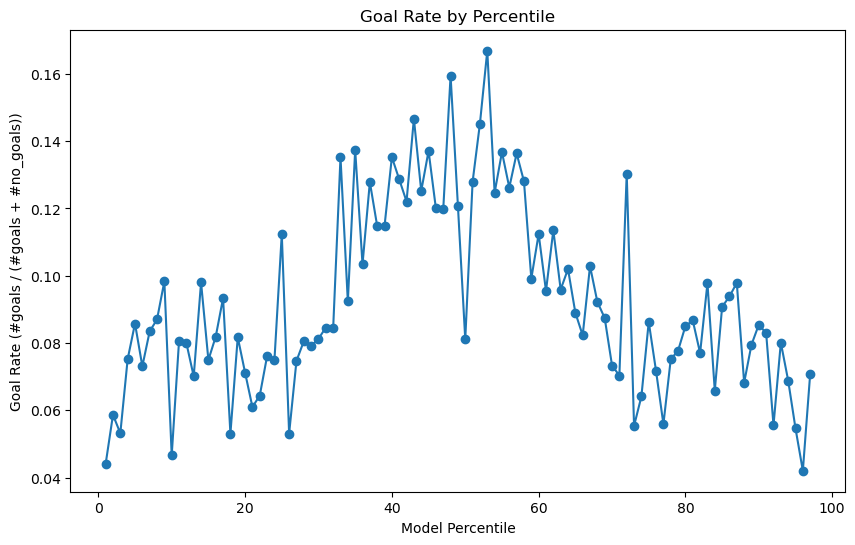

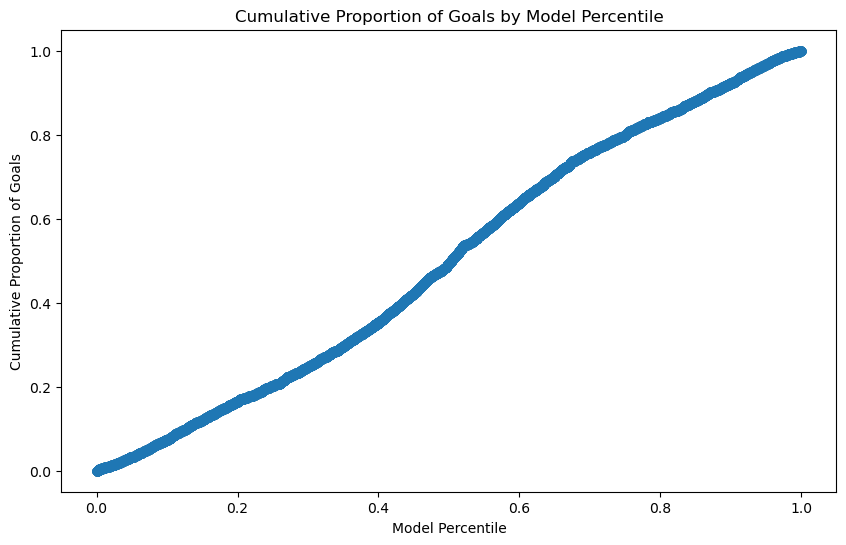

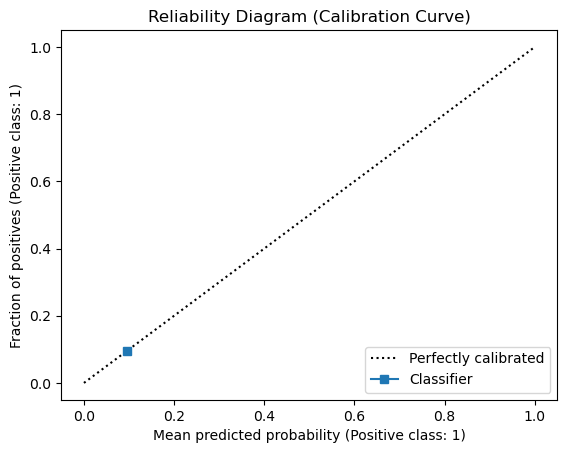

Angle Only Accuracy: 0.91


In [23]:
roc_curve_and_auc(y_val, predictions["Angle Only"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Angle Only"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Angle Only"]["y_prob"])

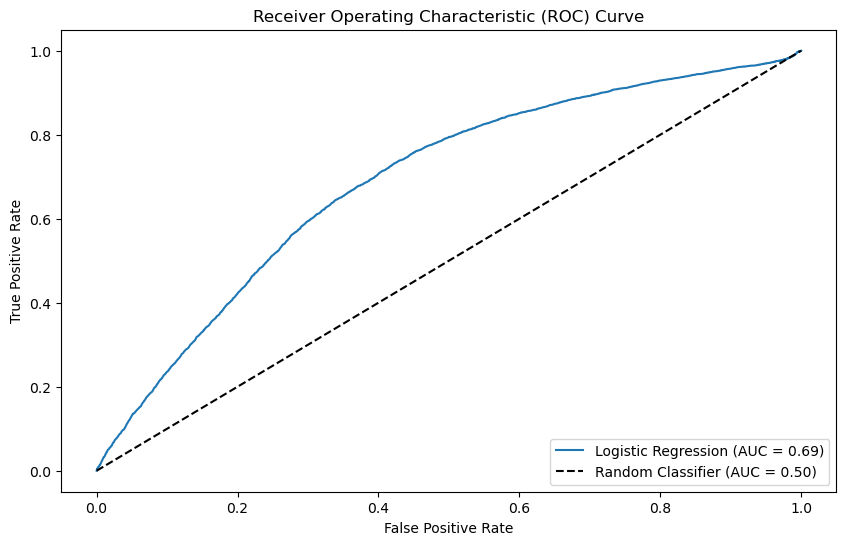

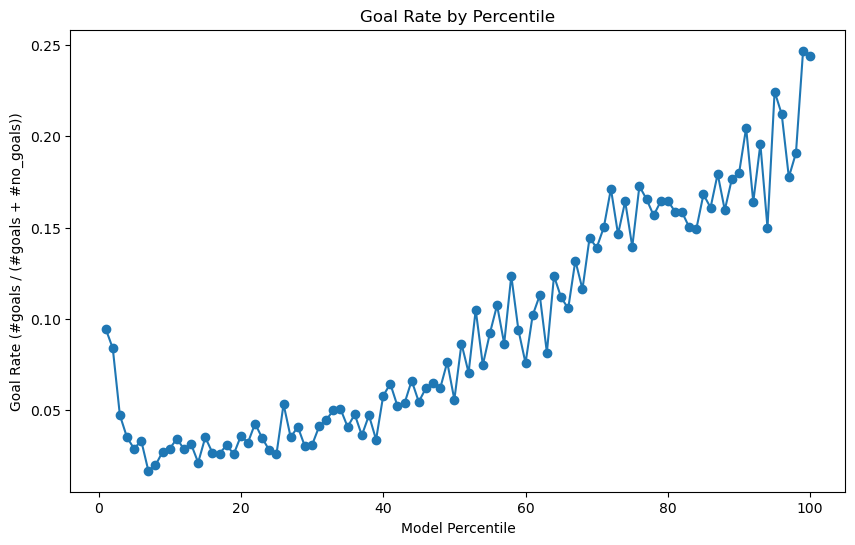

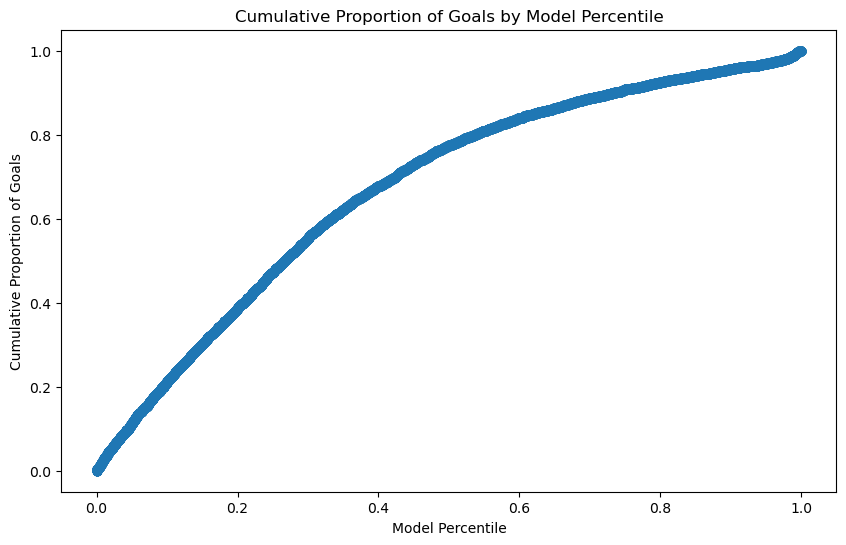

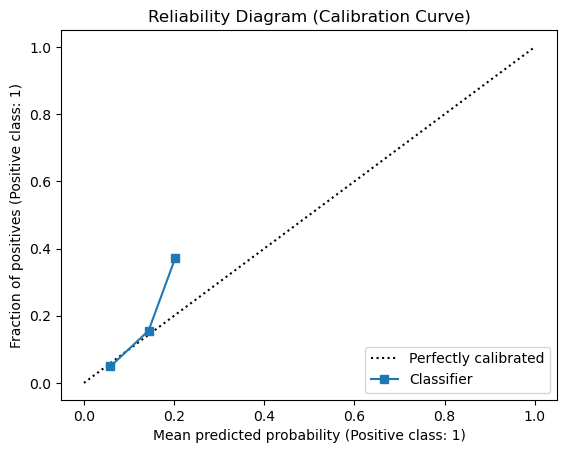

Distance + Angle Accuracy: 0.91


In [25]:
roc_curve_and_auc(y_val, predictions["Distance + Angle"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Distance + Angle"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Distance + Angle"]["y_prob"])

In [20]:
# Random Baseline
predictions["Random Baseline"] = {
    "y_prob": np.random.uniform(0, 1, len(y_val))
}

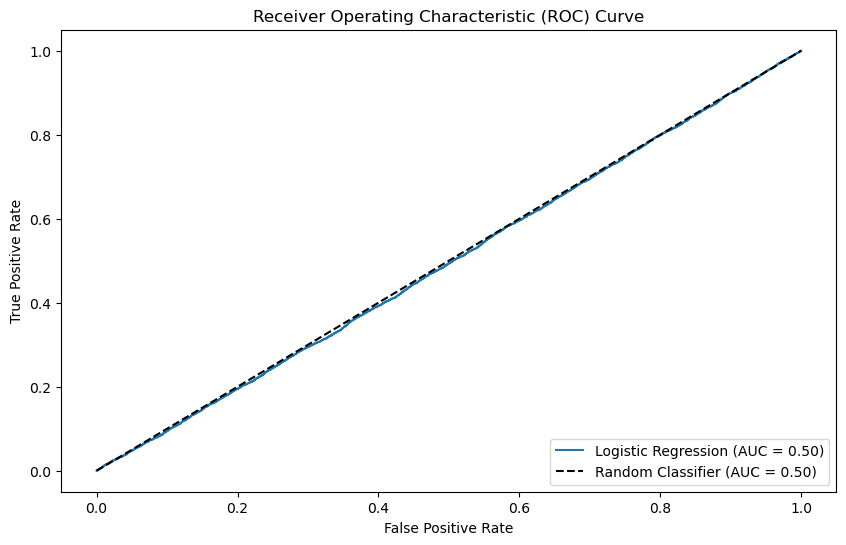

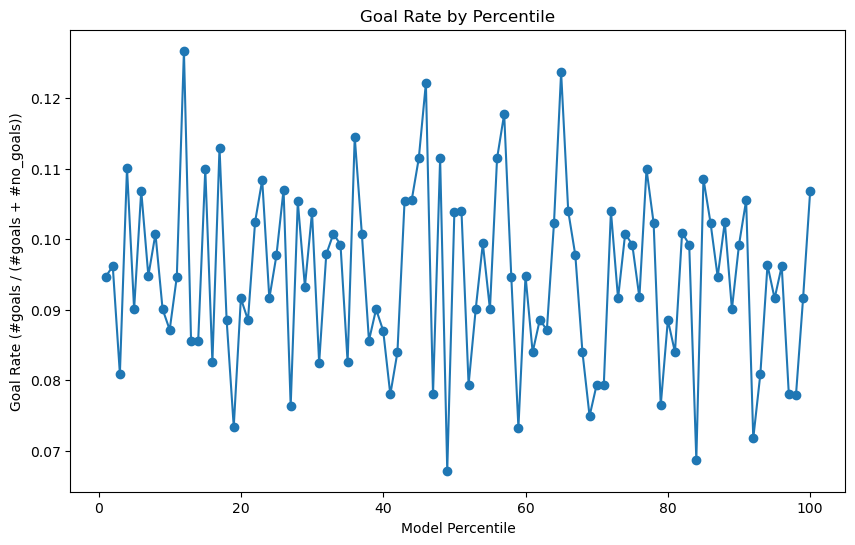

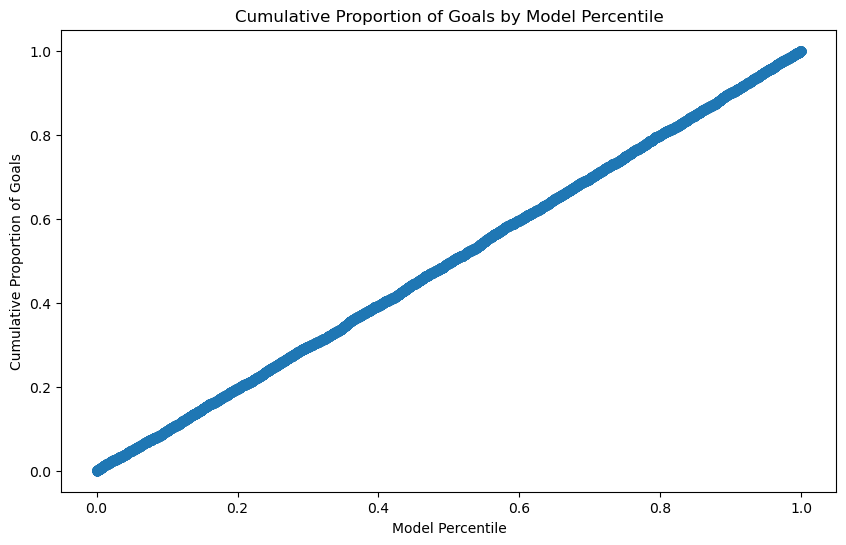

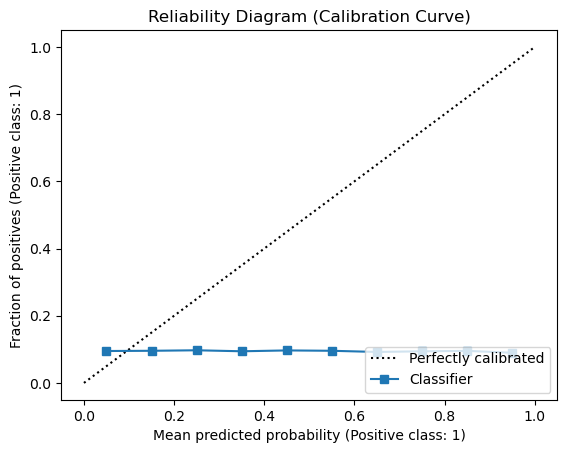

In [21]:
roc_curve_and_auc(y_val, predictions["Random Baseline"]["y_prob"])
goal_rate_by_percentile(y_val, predictions["Random Baseline"]["y_prob"])
cumulative_proportion_of_goals(y_val, predictions["Random Baseline"]["y_prob"])